# 3. Использование диффузионных моделей для непарного переноса стиля

На 5 лекции мы имплементировали диффузионные модели для безусловной генерации и генерации при условии метки класса. В первой части домашки мы более глубоко исследовали генерацию при условии метки класса, а во второй — условную генерацию для решения парных (в т.ч. обратных) задач. Наконец, в третьей части мы разберем два простых метода, которые позволяют применять диффузионные модели для решения непарных задач перевода между доменами (непарного переноса стиля).

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

In [3]:
%cd /kaggle/input/diffusion2

%cp cmnist_train.npz ../../working
%cp cond_cunet.pkl ../../working
%cp cunet.pkl ../../working
%cp fid.py ../../working
%cp cunet.py ../../working

%cd ../cmnist
%cp cmnist_train_3.npz ../../working

%cd ../../working


/kaggle/input/diffusion2
/kaggle/input/cmnist
/kaggle/working


## Цветной MNIST

В домашке предлагается поработать с цветной модификацией датасета MNIST (код для покраски взят [у коллег](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/tools.py) из Сколтеха). С одной стороны, такой датасет все еще оставляет возможность обучать диффузионные модели, но делает свойства модели более интерпретируемыми (например, в задачах условной генерации, таких, как дорисовывание, повышение разрешения и деблюринг, можно отследить корректное сохранение цвета изображения).

In [4]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [5]:
transform = Compose([Resize((32, 32)), ToTensor()])
# data_train = ColoredMNIST(root='.', train=True, download=False, transform=transform)
data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 15895675.40it/s]


Extracting ./ColoredMNIST/raw/train-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 471469.86it/s]


Extracting ./ColoredMNIST/raw/train-labels-idx1-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4403646.37it/s]


Extracting ./ColoredMNIST/raw/t10k-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2208756.96it/s]

Extracting ./ColoredMNIST/raw/t10k-labels-idx1-ubyte.gz to ./ColoredMNIST/raw



In [6]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()


## Предобученная диффузионная модель

Для дальнейшей работы с разного вида условной генерации нам понадобится предобученная **условная** диффузионная модель. Мы будем использовать простенькую архитектуру, которая была получена скрещиванием CUNet из того же [репозитория](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/cunet.py) и части, кодирующей момент времени и метку класса, из SongUNet в [EDM](https://github.com/NVlabs/edm/blob/main/training/networks.py).

Такой выбор был мотивирован следующими наблюдениями:
* Готовые качественные архитектуры (те же SongUNet или DhariwalUNet) достаточно долго работают из-за своей глубины, что усложнит решение домашки, в которой, в основном, важны качественные результаты;
* Существующие имплементации этих архитектур достаточно абстрактно написаны, чтобы при первом знакомстве было удобно писать для них разного рода надстройки.

Архитектура CUNet представляет собой гораздо более легкую и неглубокую модель, за счет чего существенно ускоряет работу с ней и упрощает ее модификацию. Кодирование метки класса и момента времени везде более-менее одинаково (и включает в себя позиционное кодирование/positional encoding), поэтому выбор именно варианта из EDM не существенен.

Как и в семинаре, мы используем надстройку над архитектурой, которая делает все необходимые преобразования над входами: нормирование, взятие логарифма от уровня шума и т.д. Ее имплементация на этот раз взята из репозитория EDM, поэтому загрузка модели выглядит немного необычным образом. Можно не обращать внимания на устройство кода в следующих двух ячейках (небольшая часть кода из гитхаба EDM была изменена для удобства использования в ноутбуке).

In [7]:
!git clone https://github.com/NVlabs/edm
!cp edm/training/networks.py edm/training/networks_copy.py
!cp fid.py edm/fid.py

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 32.98 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [8]:
def append_code(in_files, out_file):
    lines = ['\n']
    for in_file in in_files:
        with open(in_file, 'r') as f:
            for line in f:
                lines.append(line)

    with open(out_file, 'w') as f:
        for line in lines:
            f.write(line)

append_code(['edm/training/networks_copy.py', 'cunet.py'], 'edm/training/networks.py')

In [9]:
import pickle
%cd edm
from training.networks import EDMPrecond
from torch_utils import misc
from dnnlib import util
%cd ..

cond_model = EDMPrecond(img_resolution=32, img_channels=3, model_type='CUNet', noise_channels=128, base_factor=64, emb_channels=128, label_dim=11)
cond_model.eval().cuda()

with util.open_url('cond_cunet.pkl') as f:
    data = pickle.load(f)

misc.copy_params_and_buffers(src_module=data['ema'], dst_module=cond_model, require_all=True)
print(f"Модель имеет {sum(p.numel() for p in cond_model.parameters())} параметров")

/kaggle/working/edm
/kaggle/working
Модель имеет 17549763 параметров


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Возьмем слегка модифицированный код для генерации и визуализации из семинара и посмотрим, как работает модель:

In [10]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def velocity_from_denoiser(x, model, sigma, class_labels=None, error_eps=1e-4, stochastic=False, cfg=0.0, **model_kwargs):
    sigma = sigma[:, None, None, None]
    cond_v = (-model(x, sigma, class_labels, **model_kwargs) + x) / (sigma + error_eps)

    if cfg > 0.0:
        dummy_labels = torch.zeros_like(class_labels)
        dummy_labels[:, -1] = 1
        uncond_v = (-model(x, sigma, dummy_labels, **model_kwargs) + x) / (sigma + error_eps)
        v = cond_v + cfg * (cond_v - uncond_v)
    else:
        v = cond_v

    if stochastic:
        v = v * 2

    return v

def get_timesteps(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']

    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], cfg=params['cfg'], **model_kwargs) * (t_next - t_cur)
            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def visualize_model_samples(model, params, labels_usage='dummy', class_labels=None, title='Семплы из модели', **model_kwargs):
    noise = torch.randn(40, 3, 32, 32, device=params['device'])
    if class_labels is None and labels_usage == 'dummy':
        class_labels = torch.zeros(40, 11, device=params['device'])
        class_labels[:, -1] = 1
    elif labels_usage == 'random':
        class_labels = torch.randint(low=0, high=10, size=(40,), device=params['device'])
        class_labels = (class_labels[:, None] == torch.arange(11, device=params['device'])[None, :]).float()

    out, trajectory = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

Визуализируем условные семплы из модели (мы будем использовать коэффициент classifier-free guidance, равный 1).

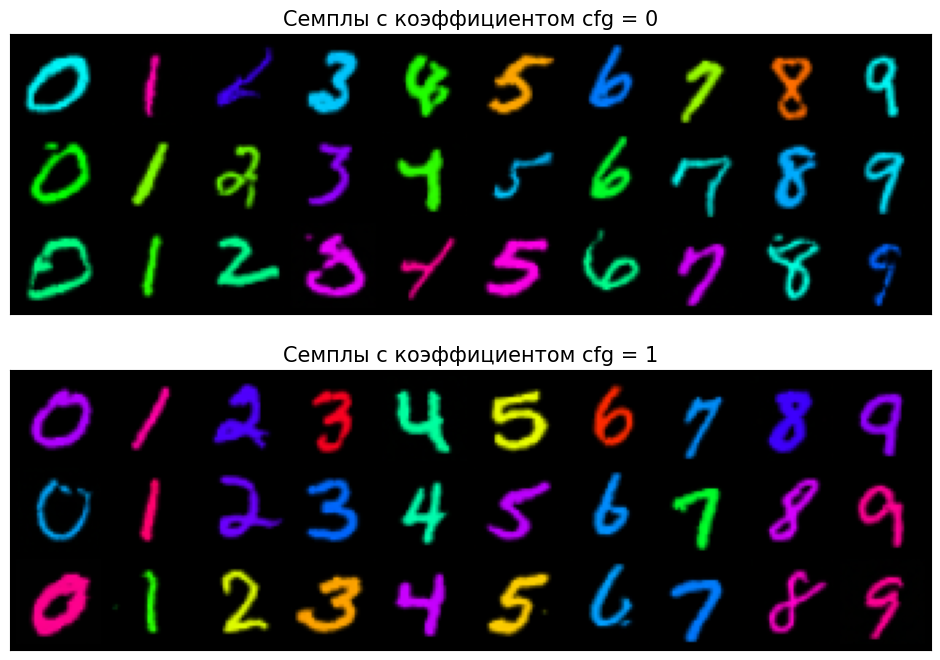

In [11]:
def visualize_cond_samples(model, params, n_samples=3, cfgs=[0.0, 0.5, 1.0, 2.0], **model_kwargs):
    fig, ax = plt.subplots(len(cfgs), figsize=(12, 8))
    for i in range(len(cfgs)):
        remove_ticks(ax[i])
        ax[i].set_title('Семплы с коэффициентом cfg = %.4g' % cfgs[i], fontsize=15)

    for i in range(len(cfgs)):
        cfg = cfgs[i]
        noise = torch.randn(n_samples * 10, 3, 32, 32, device=params['device'])
        class_labels = torch.eye(n=10, m=11).unsqueeze(0).repeat(n_samples, 1, 1).reshape(-1, 11).float().to(params['device'])
        params['cfg'] = cfgs[i]
        img, _ = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
        img = img * 0.5 + 0.5
        img_grid = make_grid(img, nrow=10)
        ax[i].imshow(img_grid.permute(1, 2, 0).detach().cpu())

sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
}

visualize_cond_samples(cond_model, sampling_params, cfgs=[0.0, 1.0])

## Непарные задачи перевода между доменами

Задача переноса стиля (перевода между доменами) ставит перед собой построение отображения $G(\mathbf{X})$ между двумя распределениями $p$ и $q$: то есть, такого отображения, что если $\mathbf{X} \sim p$, то $G(\mathbf{X}) \sim q$. Любое ли отображение с таким свойством подойдет? Нет, потому что в таком случае мы будем, например, считать решением задачи превращения кошки в собаку отображение $G$, которое переводит кошку в произвольную собаку, не имеющую ничего общего со входным изображением. Нам же хотелось бы гарантировать связь между входом и выходом. Дальше на курсе мы формализуем эту идею с помощью задачи оптимального транспорта.

Непарными же считаются задачи, в которых в данных нет явного соответствия между объектами двух доменов (например, в задаче превратить кошку в собаку или мужчину в женщину не очень понятно, как именно выбирать соответствующие пары). Здесь мы просто считаем, что нам дано два независимых набора данных, соответствующих $\mathbf{X} \sim p$ и $\mathbf{Y} \sim q$.

В этой части домашки мы будем решать задачу перевода между распределением $p(\mathbf{x})$, соответствующим распределению цифр из MNIST и $q(\mathbf{x})$, соответствующим распределению одного из классов MNIST (например, распределение троек).

## SDEdit

Оба метода основываются на одной и той же идее: если у нас есть диффузионная модель, способная генерировать тройки (например, безусловная модель, обученная на тройках, или условная модель, обученная на всем датасете), то чисто теоретически можно превратить любую цифру в тройку следующим образом:
* Зашумить цифру $\mathbf{X}$ до такого уровня $t$, что очертания, позволяющие определить цифру по $\mathbf{X} + t \varepsilon$, размываются, но остаются различимыми такие более общие черты, как цвет/толщина и т.д.;
* Запустить с помощью "троечной" диффузионной модели процесс расшумления, начав его с момента времени $t$ и семпла $\mathbf{X}_t$.

В идеале, генерация с помощью троечной диффузионной модели позволит нам получить правдоподобную тройку, а черты, оставшиеся в картинке после зашумления, позволят на каком-то уровне сохранить стиль исходной цифры. Данный метод называется [SDEdit](https://arxiv.org/abs/2108.01073).

## Задача 1

* **(0.2 балла)** Имплементируйте SDEdit для перевода произвольной цифры в цифру фиксированного класса (передав соответствующую метку в предобученную условную модель). Обратите внимание, что наша имплементация семплинга по схеме Эйлера ждет на вход $X_t / t$, поскольку в коде вход умножается на $t$;
* **(0.2 балла)** Проанализируйте, как меняется качество работы модели при изменении ее единственного гиперпараметра — уровня шума $t$, который прибавляется к исходной цифре. Возьмите по одной цифре из каждого класса и визуализируйте выходы метода при разных $t$. Поэкспериментируйте с разными $t$, чтобы визуализировать такие $t$, между которыми качественно меняется работа метода (например, сравнивать метод на $t = 79.0$ и $t = 80.0$ нет смысла). Как при изменении $t$ изменяется качество семплов и их похожесть на вход? Какой уровень шума $t$ вы бы предложили использовать?

In [12]:
def sdedit(model, x_source, target_label, params):
    noise = torch.randn_like(x_source)
    x = x_source + noise * params['sigma_max']
    class_labels = torch.zeros(x_source.shape[0], 11, device=params['device'])
    class_labels[:, target_label] = 1.0
    out, history = sample_euler(model, x / params['sigma_max'], params, class_labels)
    return out, history

In [13]:
def visualize_transform(batch, batch_out, title=""):
    batch_cat = torch.cat((batch, batch_out), dim=0)
    image_grid = make_grid(batch_cat.cpu(), nrow=len(batch))

    fig, ax = plt.subplots(figsize=(3 * len(batch), 3))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(image_grid.permute(1, 2, 0))
    plt.show()

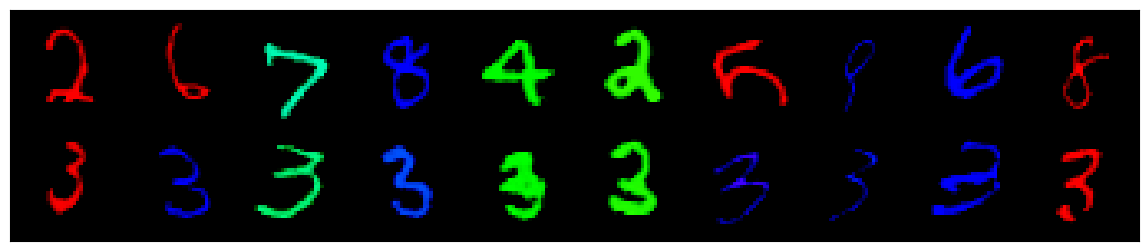

In [55]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 3.5,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}

x_source = (next(iter(train_dataloader))[0] * 2 - 1).cuda()[:10]
x_out, _ = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
visualize_transform(x_source, x_out)

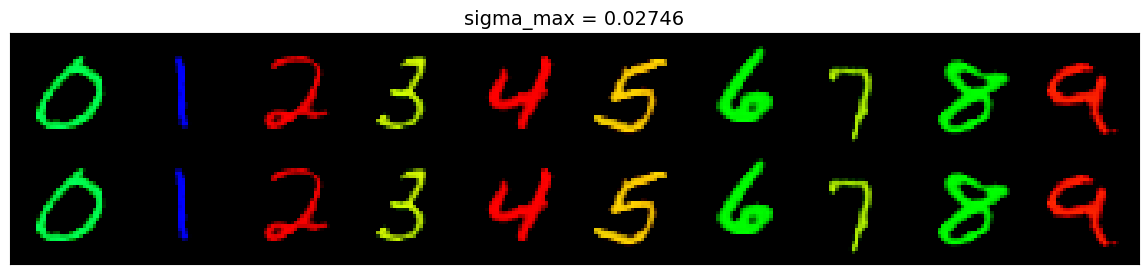

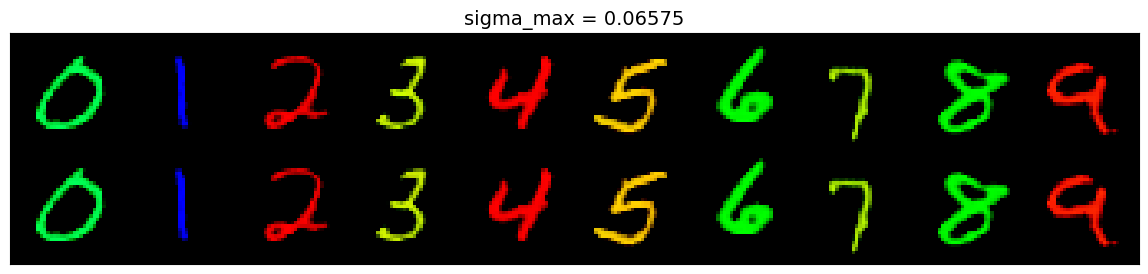

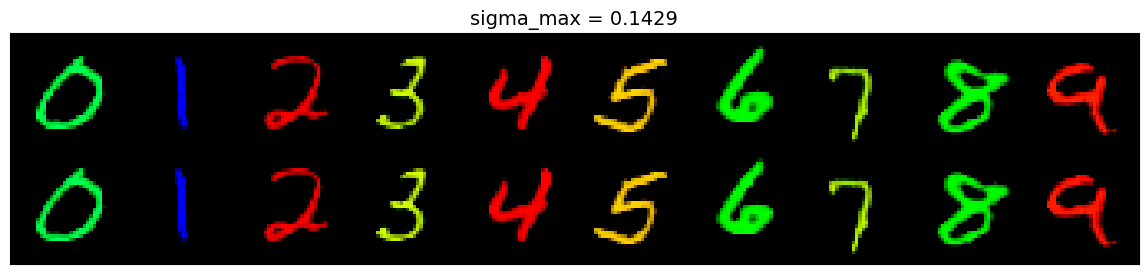

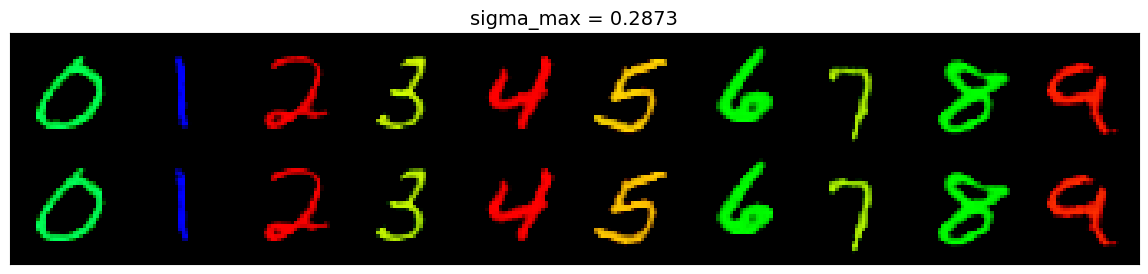

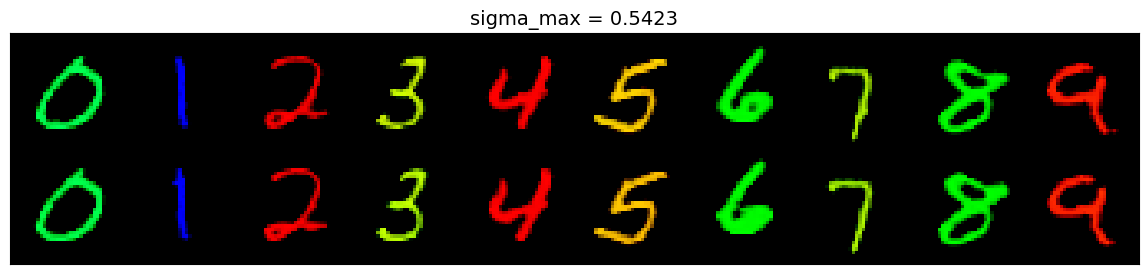

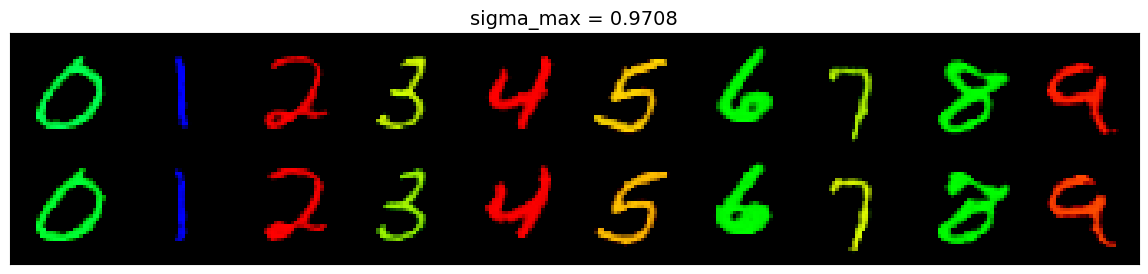

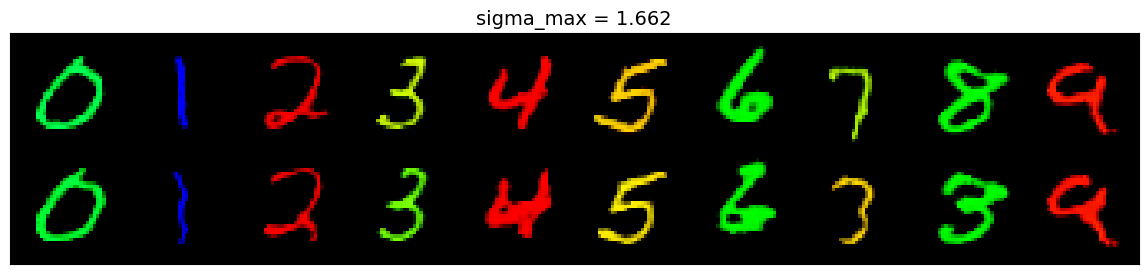

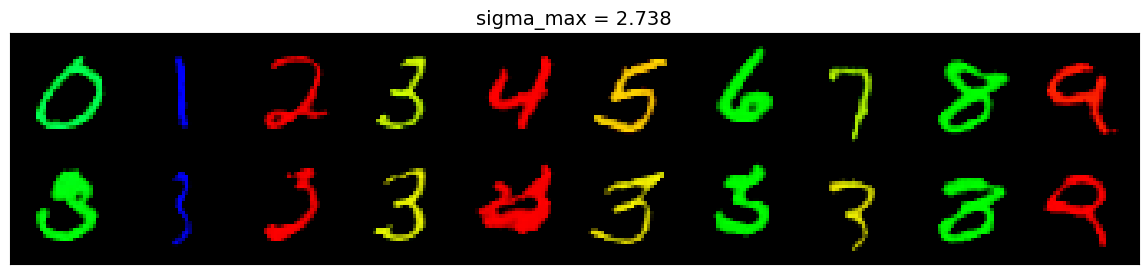

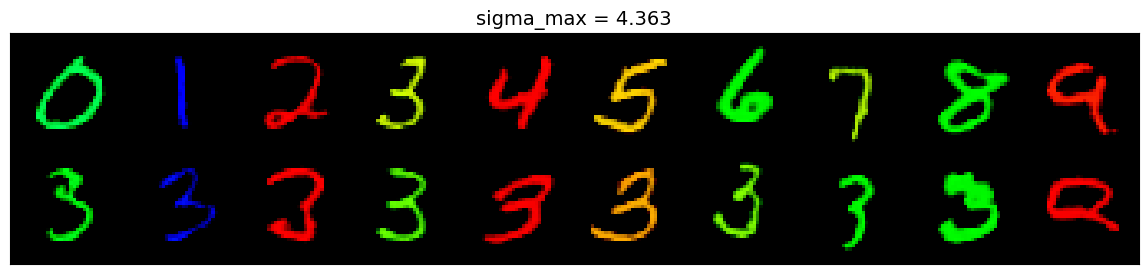

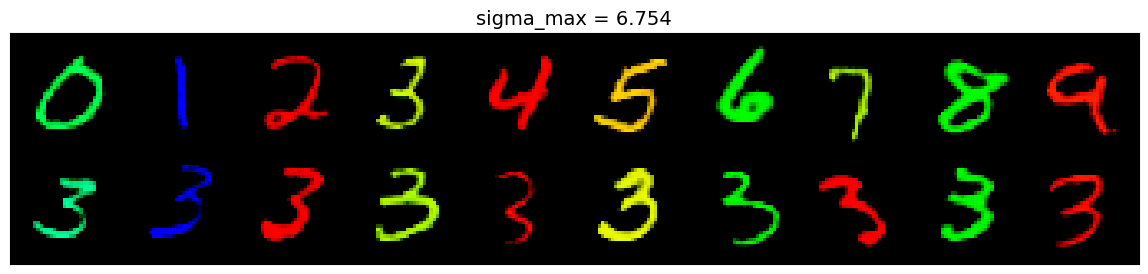

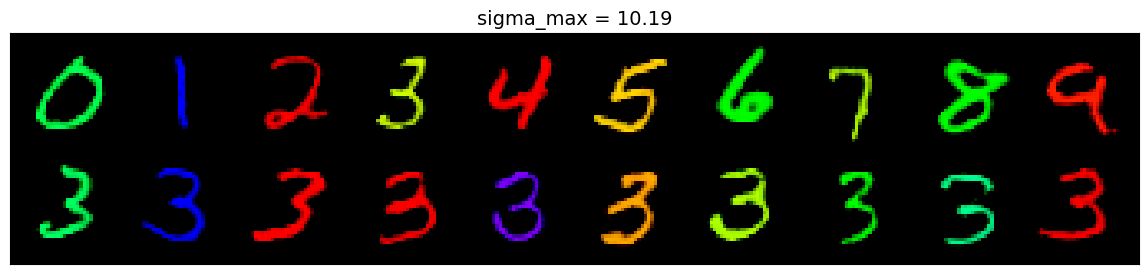

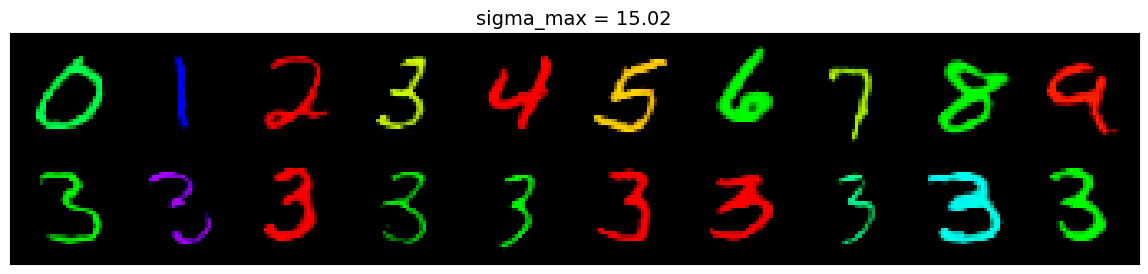

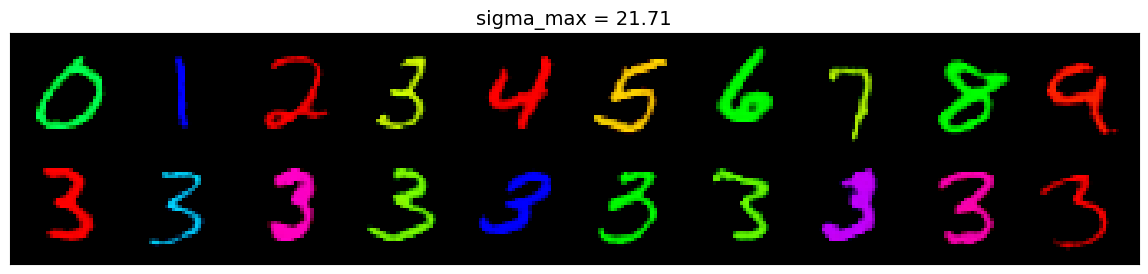

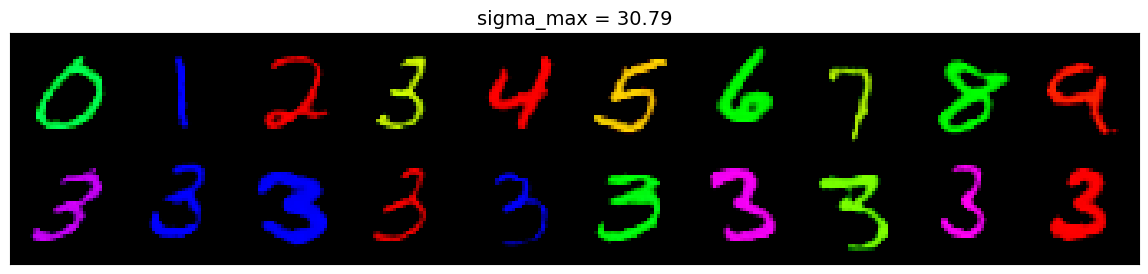

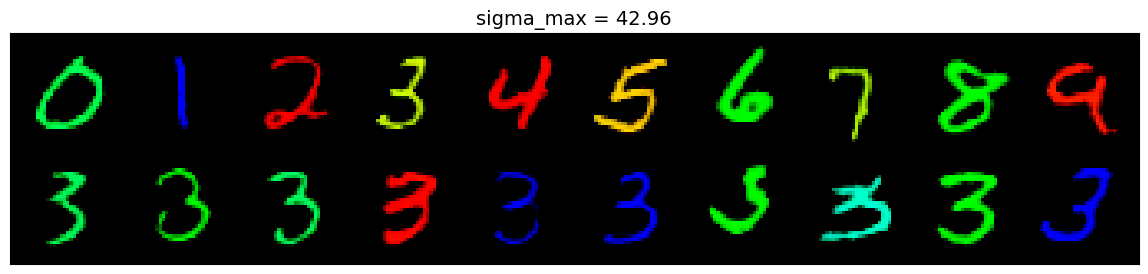

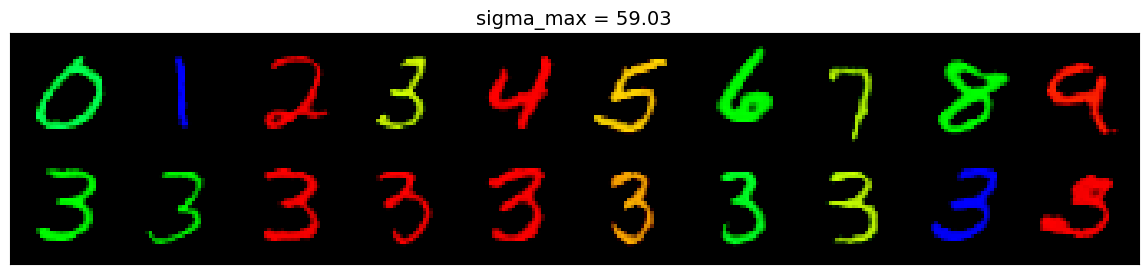

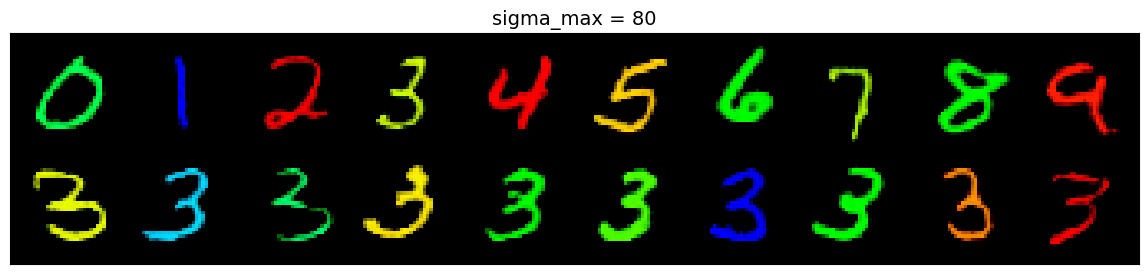

In [15]:
noise_ = torch.randn(10, 3, 32, 32).cuda()

def get_sort_image(model, params, **model_kwargs):
    params['sigma_max'] = 80
    class_labels = torch.eye(n=10, m=11).float().to(params['device'])
    x_source, _ = sample_euler(model, noise_, params, class_labels=class_labels, **model_kwargs)
    return x_source

times = get_timesteps({
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}).cpu().detach().numpy()[::-1][2:]

for time in times[::3]:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 1.0
    }
    x_source = get_sort_image(cond_model, sampling_params)
    sampling_params['sigma_max'] = time
    x_out, _ = sdedit(cond_model, x_source, target_label=3, params=sampling_params)
    visualize_transform(x_source, x_out, f"sigma_max = %.4g" % time)

Видно, что если время очень маленькое, то картинка почти не изменяется, то есть мы не успеваем "подмешать" информацию о 3. При этом, если выбрать время слишком большим, то исходная информацию о картинки просто исчезнет и 3 будет генерироваться с нуля. Мне кажется, оптимальным тут будет время в диапозоне от 2.5 до 3.0

## DDIB (Dual Diffusion Implicit Bridges)

Следующий метод, который мы рассмотрим, называется Dual Diffusion Implicit Bridges [(DDIB)](https://arxiv.org/abs/2203.08382). Он использует ту же идею, что SDEdit (зашумить семпл из исходного домена и расшумить его диффузионной моделью для целевого домена), но делает это более умно. Принципиальная проблема SDEdit состоит в том, что стохастическое зашумление всегда сопровождается потерей данных об исходном изображении (если $t$ слишком большое, то можно считать, что информации вообще никакой не остается). Если бы был способ детерминированного зашумления данных, это бы решило проблему, так как позволило бы превратить вход во что-то, что может принять на вход диффузионная модель для таргетного домена.

А такой способ у нас есть! Подойдет представление диффузионных моделей через обыкновенные дифференциальные уравнения: прямой процесс зашумления
$$
    \mathrm{d} \mathbf{X}_t = g(t) \mathrm{d} \mathbf{W}_t
$$
эквивалентен ОДУ
$$
    \mathrm{d} \mathbf{Y}_t = -\frac{g^2(t)}{2} \nabla \log p_t(\mathbf{Y}_t) \mathrm{d} t
$$
с точки зрения маргинальных распределений в каждый момент времени $t$. Тогда зашумить изображение из исходного домена можно решив соответствующее ОДУ с момента времени $0$ до момента времени $t$. Все, что для этого нужно, — иметь диффузионную модель для исходного домена (а такая модель в нашем сеттинге с условной моделью на MNIST'e есть).  Полученное зашумленное изображение, как и раньше, подается в диффузионную модель для целевого домена и расшумляется.

## Задача 2
* **(0.3 балла)** Реализуйте детерминированное зашумление изображения с помощью метода Эйлера, взяв $\sigma_t = t$ и $g(t) = \sqrt{2t}$ (именно эти параметры мы взяли в 5 лекции, с ними имплементировали схему Эйлера, которую потом скопировали во все 3 части домашки). На его основе релизуйте метод DDIB. Так как работаем мы с переводом произвольной цифры в, например, тройку, при зашумлении изображения мы будем подавать на вход сети его метку класса, а при расшумлении — метку целевого класса. При зашумлении тоже имеет смысл использовать CFG.

* Как и в SDEdit, обратите внимание, что наша имплементация семплинга по схеме Эйлера ждет на вход $X_t / t$, поскольку в коде вход умножается на $t$;

* **(0.1 балл)** Визуализируйте траекторию зашумления и расшумления изображения при выборе максимального $t = T$ (80.0 в наших экспериментах). Похож ли "детерминированный шум", полученный при кодировании входа, на семпл из нормального распределения? При визуализации траектории имеет смысл нормировать промежуточные изображения (например, так, как это делается в лекции 5).

  
* **(0.2 балла, копипаста из SDEdit)** Проанализируйте, как меняется качество работы модели при изменении ее единственного гиперпараметра — уровня шума $t$, до которого кодируется исходная картинка. Возьмите по одной цифре из каждого класса и визуализируйте выходы метода при разных $t$. Поэкспериментируйте с разными $t$, чтобы визуализировать такие $t$, между которыми качественно меняется работа метода. Как при изменении $t$ изменяется качество семплов и их похожесть на вход? Какой уровень шума $t$ вы бы предложили использовать?

In [20]:
def encode_euler(model, x_source, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = torch.flip(get_timesteps(params), (-1, ))
    x = x_source

    x_history = [normalize(x)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = (t_steps[i] + 1e-2) * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels, cfg=params['cfg']) * (t_next - t_cur)

            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def ddib(model, x_source, x_labels, target_label, params):
    if x_labels is not None:
        x_labels = (x_labels[:, None] == torch.arange(11, device=params['device'])[None, :]).float()
    noise, noise_history = encode_euler(model, x_source, params, x_labels)
    class_labels = torch.zeros(x_source.shape[0], 11, device=params['device'])
    class_labels[:, target_label] = 1.0
    out, denoise_history = sample_euler(model, noise / params['sigma_max'], params, class_labels)
    return out, noise_history, denoise_history

In [21]:
def visualize_trajectory(model, noise_history, denoise_history):
    noise_history = torch.stack(noise_history, dim=1) * 0.5 + 0.5
    denoise_history = torch.stack(denoise_history, dim=1) * 0.5 + 0.5
    trajectory = torch.cat([noise_history, denoise_history], dim=1).reshape(-1, *noise_history.shape[-3:])
    img_grid = make_grid(trajectory, nrow=len(trajectory) // len(noise_history))
    fig, ax = plt.subplots(1, figsize=(12, 5))
    remove_ticks(ax)
    ax.imshow(img_grid.permute(1, 2, 0).detach().cpu())
    ax.set_title('Траектория зашумления и расшумления', fontsize=17)

In [31]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 10,
    'cfg': 1.0,
    'stochastic': False
}

batch = next(iter(train_dataloader))
x_source = (batch[0] * 2 - 1).cuda()[:6]
x_labels = batch[1].cuda()[:6]
x_out, noise_history, denoise_history = ddib(cond_model, x_source, x_labels, target_label=3, params=sampling_params)

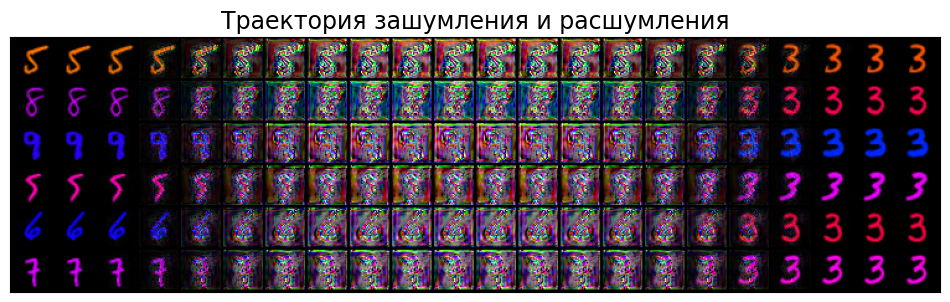

In [32]:
visualize_trajectory(cond_model, noise_history, denoise_history)

Ну шум немного похож на нормальный, но вот контур числа остаётся даже при полном зашумлении.

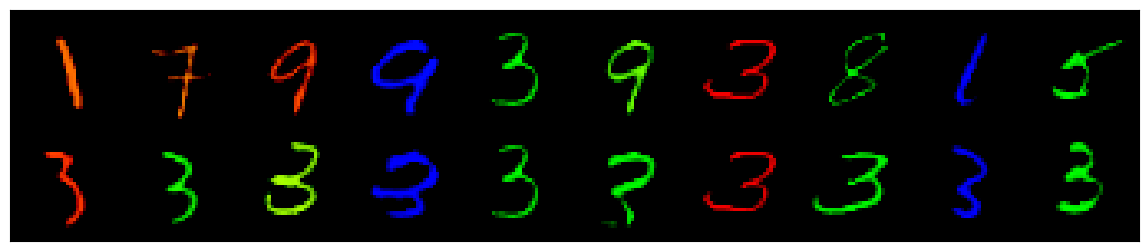

In [33]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 5,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'cfg': 2.0,
    'stochastic': False
}

batch = next(iter(train_dataloader))
x_source = (batch[0] * 2 - 1).cuda()[:10]
x_labels = batch[1].cuda()[:10]
x_out, _, _ = ddib(cond_model, x_source, x_labels, target_label=3, params=sampling_params)
visualize_transform(x_source, x_out)

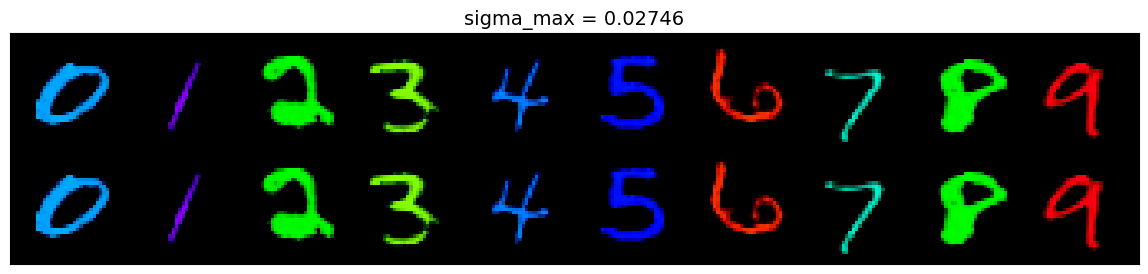

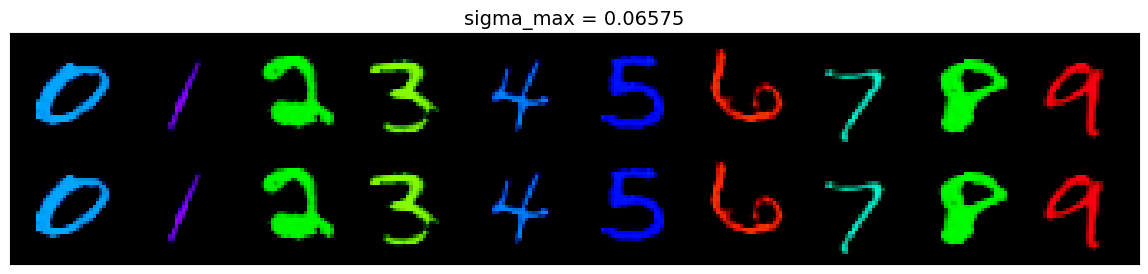

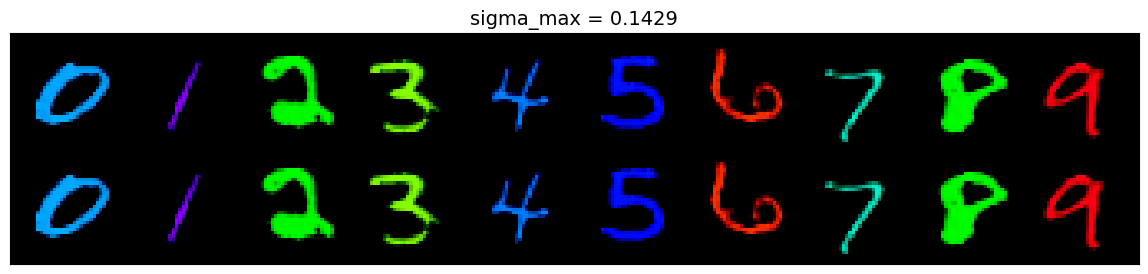

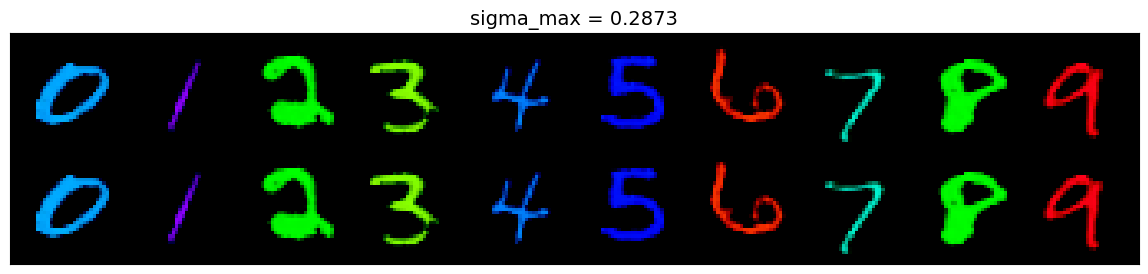

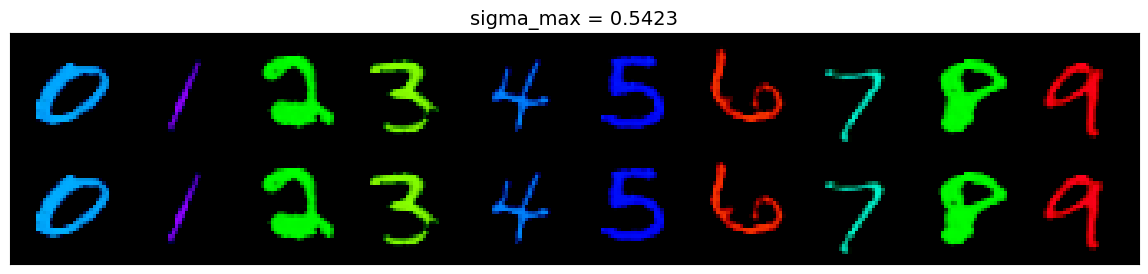

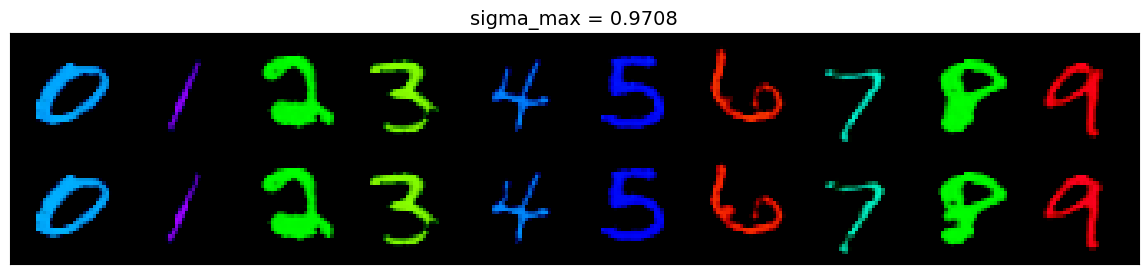

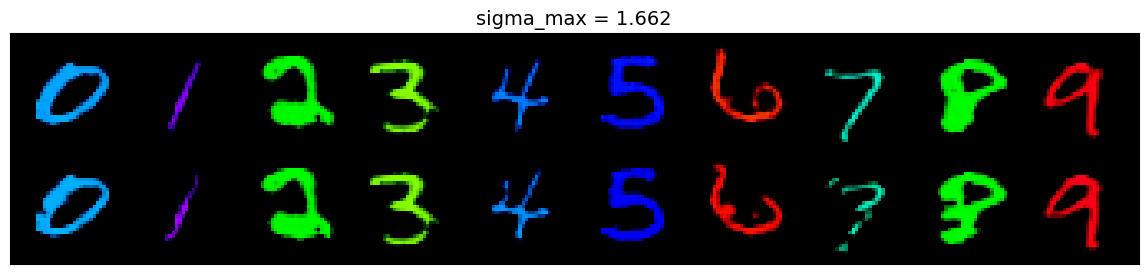

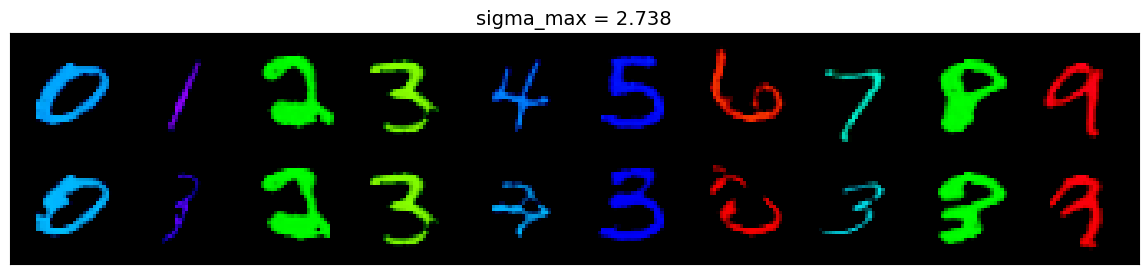

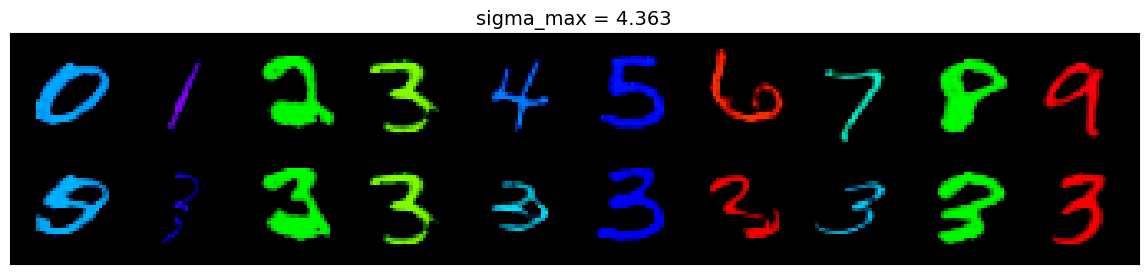

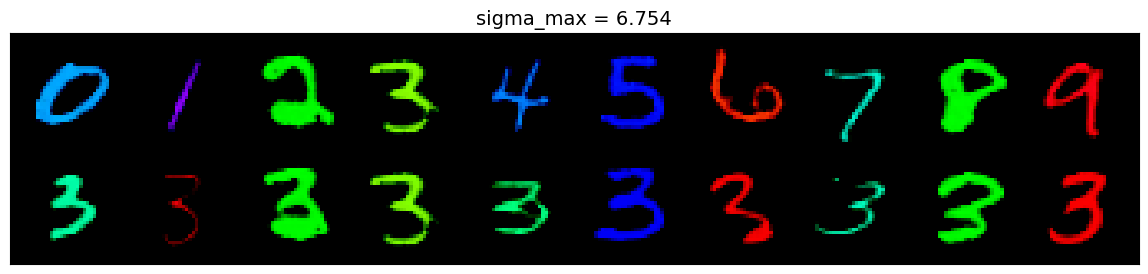

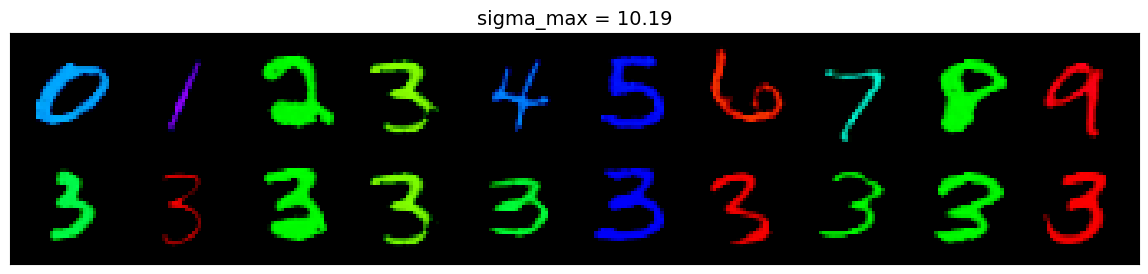

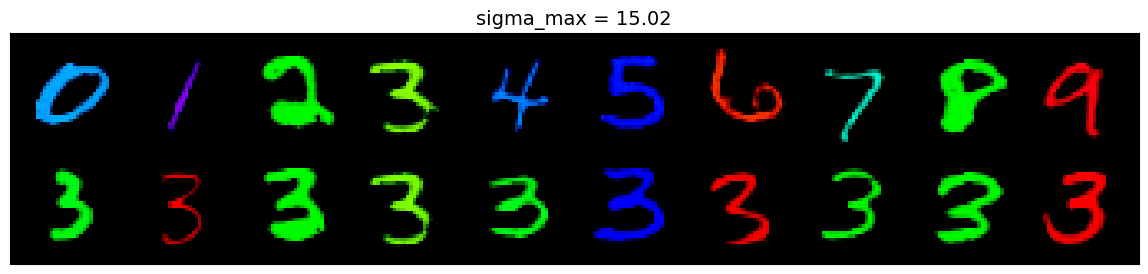

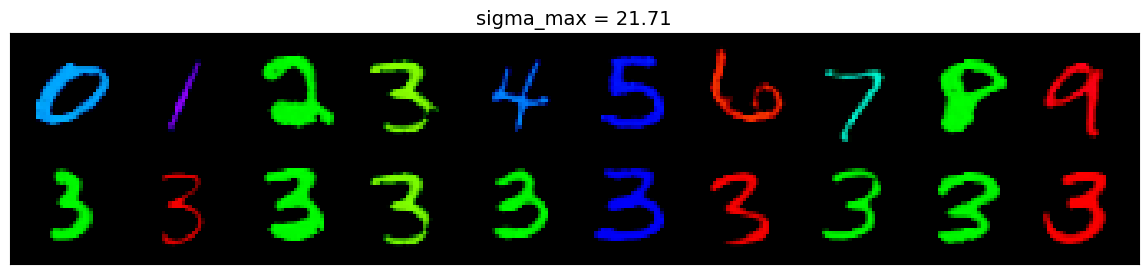

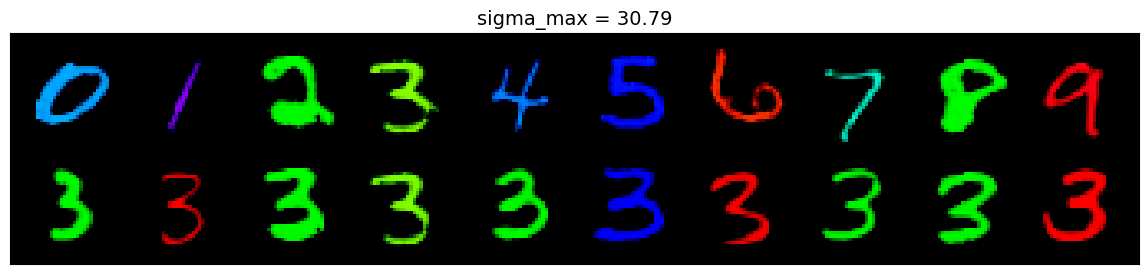

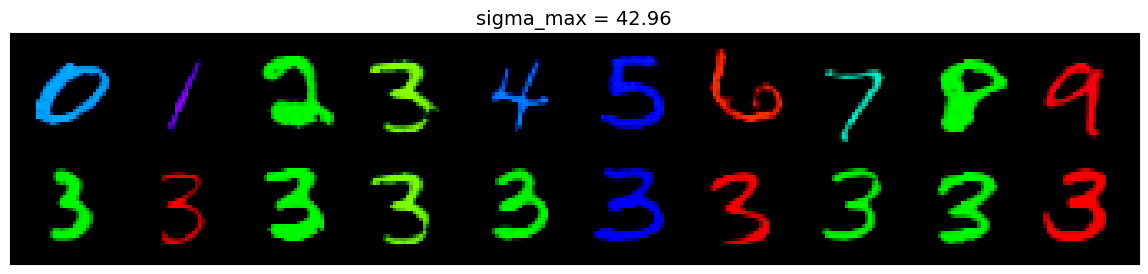

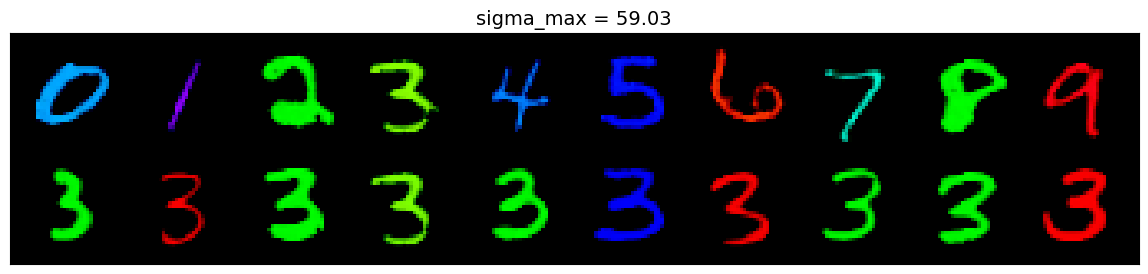

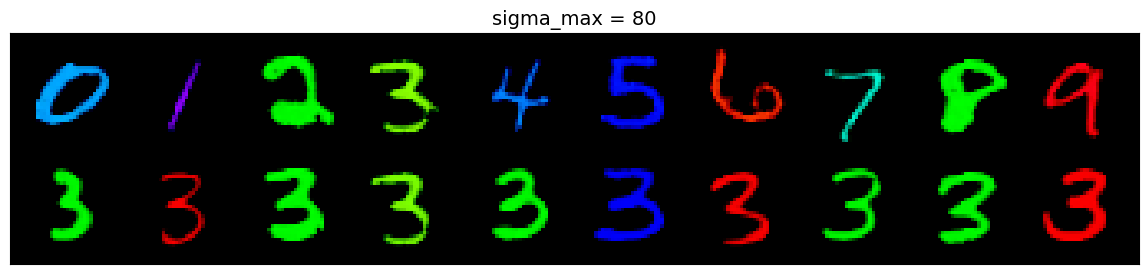

In [34]:
noise_ = torch.randn(10, 3, 32, 32).cuda()

def get_sort_image(model, params, **model_kwargs):
    params['sigma_max'] = 80
    class_labels = torch.eye(n=10, m=11).float().to(params['device'])
    x_source, _ = sample_euler(model, noise_, params, class_labels=class_labels, **model_kwargs)
    return x_source, torch.arange(10).to(params['device'])

times = get_timesteps({
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False,
    'cfg': 1.0
}).cpu().detach().numpy()[::-1][2:]

for time in times[::3]:
    sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 1.0
    }
    x_source, x_labels = get_sort_image(cond_model, sampling_params)
    sampling_params['sigma_max'] = time
    x_out, _, _ = ddib(cond_model, x_source, x_labels, target_label=3, params=sampling_params)
    visualize_transform(x_source, x_out, f"sigma_max = %.4g" % time)

## Задача 3 (бонус, 0.5 балла)

Возьмите по 3-5 (адекватных) значений $t$ для каждого из двух методов. Для каждого $t$ запустите метод (с тройками в качестве целевого домена) на подмножестве тестового датасета MNIST (1000-2000 картинок) и посчитайте две метрики:
* Средняя по датасету "похожесть" между входом и выходом, посчитанная как попиксельная $L_2$ норма разности;
* FID между сгенерированными тройками и тройками из трейн датасета (предпосчитанные статистики лежат в *cmnist_train_3.npz*).

Визуализируйте полученные метрики в виде двумерного scatter plot с осями, соответствующими метрикам, и прокомментируйте результаты. Какой из методов достигает лучшего баланса между качеством семплов и похожестью входа на выход?

In [42]:
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)

In [43]:
sampling_params = {
        'device': 'cuda',
        'sigma_min': 0.02,
        'num_steps': 50,
        'rho': 7.0,
        'vis_steps': 1,
        'stochastic': False,
        'cfg': 1.0
    }

times_sdedit = [2, 3, 4, 5]
times_ddib = [3, 4, 5, 6]
l2_sdedit = []
l2_ddib = []

In [44]:
from tqdm import tqdm

def calc_l2(model, params, method, target_label, dataloader, batch_size, num_samples):
    count = 0
    metric = 0.0
    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            batch = next(dataloader)[:cur_batch_size]
            x_source = (batch[0] * 2 - 1).to(params['device'])
            x_labels = batch[1].to(params['device'])
            if method == sdedit:
                x_out, _ = method(model, x_source, target_label, params=sampling_params)
            else:
                x_out, _, _ = method(model, x_source, x_labels, target_label, params=sampling_params)
            
            metric += torch.sqrt(((x_out - x_source) ** 2).sum((1, 2, 3))).sum()
            count += batch_size
            pbar.update(batch_size)
            pbar.set_description("l2 calculation")
    ret = metric / (batch_size * len(dataloader) * x_out.shape[1] * x_out.shape[2] * x_out.shape[3])
    print(ret)
    return ret.item()

for time in times_sdedit:
    sampling_params['sigma_max'] = time
    torch.manual_seed(0)
    test_dataloader = DataLoader(data_test, batch_size=64)
    l2_sdedit.append(calc_l2(cond_model, sampling_params, sdedit, 3, iter(test_dataloader), test_dataloader.batch_size, num_samples=2000))
for time in times_ddib:
    sampling_params['sigma_max'] = time
    sampling_params['num_steps'] = 50
    torch.manual_seed(0)
    test_dataloader = DataLoader(data_test, batch_size=64)
    l2_ddib.append(calc_l2(cond_model, sampling_params, ddib, 3, iter(test_dataloader), test_dataloader.batch_size, num_samples=2000))

l2 calculation: : 2048it [01:29, 22.76it/s]                        


tensor(0.0007, device='cuda:0')


l2 calculation: : 2048it [01:29, 22.76it/s]                        


tensor(0.0010, device='cuda:0')


l2 calculation: : 2048it [01:29, 22.76it/s]                        


tensor(0.0012, device='cuda:0')


l2 calculation: : 2048it [01:29, 22.76it/s]                        


tensor(0.0014, device='cuda:0')


l2 calculation: : 2048it [03:00, 11.38it/s]                        


tensor(0.0007, device='cuda:0')


l2 calculation: : 2048it [02:59, 11.38it/s]                        


tensor(0.0008, device='cuda:0')


l2 calculation: : 2048it [02:59, 11.38it/s]                        


tensor(0.0009, device='cuda:0')


l2 calculation: : 2048it [02:59, 11.38it/s]                        

tensor(0.0010, device='cuda:0')


In [45]:
import os, shutil
def save_model_samples(name, model, params, method, target_label, dataloader, batch_size, num_samples, **model_kwargs):
    os.makedirs(name, exist_ok=True)
    shutil.rmtree(name)
    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            batch = next(dataloader)[:cur_batch_size]
            x_source = (batch[0] * 2 - 1).to(params['device'])
            x_labels = batch[1].to(params['device'])
            if method == sdedit:
                out, _ = method(model, x_source, target_label, params=sampling_params)
            else:
                out, _, _ = method(model, x_source, x_labels, target_label, params=sampling_params)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

for time in times_sdedit:
    sampling_params['sigma_max'] = time
    torch.manual_seed(0)
    test_dataloader = DataLoader(data_test, batch_size=64)
    save_model_samples(f'sdedit_samples_{time}', cond_model, sampling_params, sdedit, 3, iter(test_dataloader), batch_size=test_dataloader.batch_size, num_samples=2000)

for time in times_ddib:
    sampling_params['sigma_max'] = time
    sampling_params['num_steps'] = 50
    torch.manual_seed(0)
    test_dataloader = DataLoader(data_test, batch_size=64)
    save_model_samples(f'ddib_samples_{time}', cond_model, sampling_params, ddib, 3, iter(test_dataloader), batch_size=test_dataloader.batch_size, num_samples=2000)

2048 images saved: : 2048it [01:33, 21.85it/s]                        
2048 images saved: : 2048it [01:33, 21.84it/s]                        
2048 images saved: : 2048it [01:33, 21.83it/s]                        
2048 images saved: : 2048it [01:33, 21.85it/s]                        
2048 images saved: : 2048it [03:03, 11.15it/s]                        
2048 images saved: : 2048it [03:03, 11.15it/s]                        
2048 images saved: : 2048it [03:03, 11.15it/s]                        
2048 images saved: : 2048it [03:03, 11.15it/s]                        


In [46]:
%cd edm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
%cd ..

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

/kaggle/working/edm
/kaggle/working


In [47]:
fid_sdedit = []
fid_ddib = []
for time in times_sdedit:
    fid_sdedit.append(calc_fid(f'sdedit_samples_{time}', '/kaggle/input/cmnist/cmnist_train_3.npz', num_expected=2000, batch=128))
for time in times_ddib:
    fid_ddib.append(calc_fid(f'ddib_samples_{time}', '/kaggle/input/cmnist/cmnist_train_3.npz', num_expected=2000, batch=128))

Loading Inception-v3 model...


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Loading images from "sdedit_samples_2"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:04<00:00,  3.99batch/s]


Loading Inception-v3 model...
Loading images from "sdedit_samples_3"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.09batch/s]


Loading Inception-v3 model...
Loading images from "sdedit_samples_4"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.08batch/s]


Loading Inception-v3 model...
Loading images from "sdedit_samples_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.08batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_3"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.10batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_4"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.07batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_5"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.07batch/s]


Loading Inception-v3 model...
Loading images from "ddib_samples_6"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:03<00:00,  4.09batch/s]


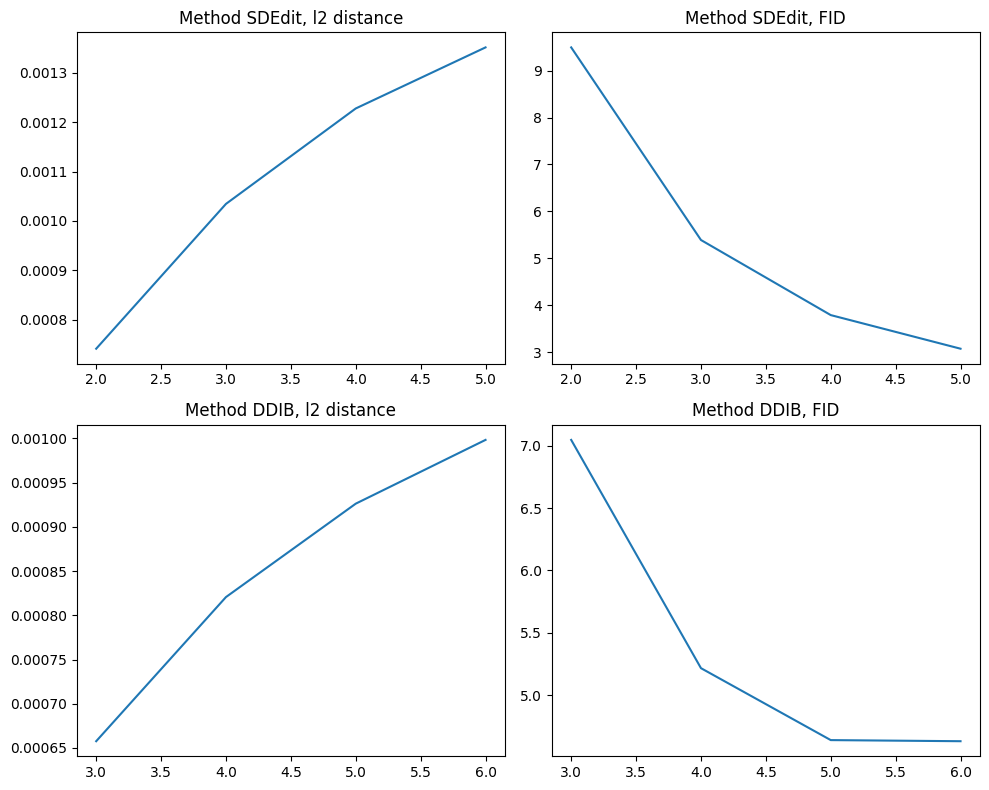

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(times_sdedit, l2_sdedit)
axs[0, 0].set_title("Method SDEdit, l2 distance")

axs[0, 1].plot(times_sdedit, fid_sdedit)
axs[0, 1].set_title("Method SDEdit, FID")

axs[1, 0].plot(times_ddib, l2_ddib)
axs[1, 0].set_title("Method DDIB, l2 distance")

axs[1, 1].plot(times_ddib, fid_ddib)
axs[1, 1].set_title("Method DDIB, FID")

plt.tight_layout()
plt.show()

По графикам видно, что DDIB лучше сохраняет исходные признаки изображения, в то время как SDEdit делает картинку более правдоподобной.